In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

This notebook was to transform some of the data through OASIS and then export it to HDF5 to send it to Mari for cross validation.

In [2]:
# Import generic libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy.io
import os, sys
import tqdm
# from scipy.optimize import curve_fit
# from pathlib import Path
# import pickle

In [3]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

In [4]:
# Import local OASIS installation
sys.path.append(os.path.expanduser('~/projects/2017-kohl/OASIS'))
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2

/home/zenke/projects/2017-kohl/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [5]:
# Import local tools
sys.path.append(os.path.expanduser('~/projects/2017-kohl/repo/'))
from pynalysis import utils

In [6]:
def datamatrix2tensor(data, event_times, toff_after, toff_before=0):
    """ Slices flat data matrix into trial based tensor.
    
    Expects data to be time x unit.
    
    Returns: A tuple of (list, tensor) in which the list contains the indices of valid trials (ie. the ones
    for which the time interval was valid) and the tensor contains the data in format trial x time x unit.
    """
    trials = []
    indices = [] 
    nb_frames = data.shape[0]
    for i,ev in enumerate(event_times):
        fr = int(ev)
        if fr<toff_before or fr>nb_frames-toff_after: continue
        s = data[fr-toff_before:fr+toff_after]
        trials.append(s)
        indices.append(i)
    return indices, np.array(trials)

In [33]:
def load_and_preprocess(area):
    """ Extract and preprocess data from HDF5 file. """
    
    elements = utils.get_hdf5group_keys(area)
    
    planes = []
    for i in range(2):
        planekey = "plane%i"%(i+1)
        if planekey in area.keys():
            planes.append(area[planekey])
    
    sessbehav=area['session_behaviour']
    print(utils.get_hdf5group_keys(sessbehav))
    
    # Extract frame rate from struct
    frate = area['plane1/fRate'][0,0]
    # print("Frame rate %f"%frate)
    
    fluo = planes[0]['fluoresence_corrected']
    time = np.arange(len(fluo))*1.0/frate
    
    # Extract event timing
#     motor_events = ['motor_start', 'motor_back', 'motor_atWhisk']
#     event_fields = []
#     event_fields.extend(motor_events)
#     event_fields.extend(['velocity', 'stim_position'])
    event_fields = utils.get_hdf5group_keys(sessbehav)
    # event_fields = ['motor_start']

    events = {}
    for f in event_fields:
        events[f] = np.array(sessbehav[f]).ravel()
                
    # tau_d = 270e-3 # GCAMP6M
    # tau_d = 142e-3 # GCAMP6F
    tau_d = 550e-3 # GCAMP6S
    tau_r = 180e-3
    
    AR1=True
    
    if AR1:
        g1 = np.exp(-1.0/(tau_d*frate))
        ginit = (g1,) 
    else:
        g1 = np.exp(-1.0/(tau_d*frate)) + np.exp(-1.0/(tau_r*frate))
        g2 = -np.exp(-1.0/(tau_d*frate))*np.exp(-1.0/(tau_r*frate))
        ginit = (g1,g2) # AR2
    # ginit = (None,)
    print(ginit)

    plane_data = []
    for plane in planes:
        # Get raw fluoresence
        fluo = np.array(plane['fluoresence_corrected'], dtype=np.float32)
    
        # Extrac cell positions
        tmp = []
        for pos in plane['position']:
            tmp.append(pos)
        positions_plane = np.array(tmp).T

        # Run OASIS on each fluorescence trace   
        traces = []
        spike_trains = []
        # TODO
        ret_values = []
        for idx in range(fluo.shape[1]):
            y = np.array(fluo[:,idx],dtype=float)
            c, s, b, g, lam = r = deconvolve(y, g=ginit, penalty=1)
            if np.isnan(c.sum()):
                traces.append(np.zeros(c.shape))
                spike_trains.append(np.zeros(s.shape))
                ret_values.append(r)
            else:
                traces.append(c)
                spike_trains.append(s)
                ret_values.append(r)
        traces = np.array(traces, dtype=np.float32).T
        spike_trains = np.array(spike_trains, dtype=np.float32).T
        
        plane_data.append( dict(fluo=fluo, spikes=spike_trains, traces=traces, pos=positions_plane) )
    
    return time, events, plane_data, frate

In [34]:
def process_hdf_path(hdf5handle, hdf5path, frames_before=15, frames_after=75):
    print("Processing %s -- %s"%(stringid,hdf5path))
    try:
        data = load_and_preprocess(hdf5handle.get(hdf5path))
    except KeyError:
        print("KeyError when preprocessing %s, probably some missing event type?"%hdf5path)
        return
    except TypeError: 
        print("Warning! Could not load %s"%expspecifier)
        return

    
    times, events, plane_data, frate = data

    trigger_times = events['motor_atWhisk']
    # extract velocity
    velocity = events['velocity'].ravel()
    if velocity.max()!=np.abs(velocity).max():
        velocity *= -1
    velocity /= velocity.max()
    valid_indices, trial_velocity = datamatrix2tensor(velocity, 
                          trigger_times, 
                          toff_before=frames_before, 
                          toff_after=frames_after)
    mean_trial_velocity = trial_velocity.mean(1)

    for plane in plane_data:
        # Create data tensor from denoised traces for all trials
        valid_indices, datatensor = datamatrix2tensor(plane["traces"], 
                                                      trigger_times, 
                                                      toff_before=frames_before,                                               
                                                      toff_after=frames_after)

        plane["datatensor"] = datatensor
        plane["valid_trials"] = valid_indices

        _, fluotensor = datamatrix2tensor(plane["fluo"], 
                                                      trigger_times, 
                                                      toff_before=frames_before,                                               
                                                      toff_after=frames_after)

        plane["fluotensor"] = fluotensor

        _, spiketensor = datamatrix2tensor(plane["spikes"], 
                                                      trigger_times, 
                                                      toff_before=frames_before,                                               
                                                      toff_after=frames_after)

        plane["spiketensor"] = spiketensor

        tmp = (datatensor-datatensor.min(0))/(datatensor.std(0)+1.0e-2)
        plane["standardized_trial_data"] = tmp.reshape((tmp.shape[0],-1))


    # extract labels
#     raw_labels = events['stim_position'].ravel()[valid_indices]
#     new_labels = 1*raw_labels
#     for i,l in enumerate(np.unique(raw_labels)):
#         new_labels[new_labels==l] = i
#     labels = new_labels

    result = dict(filename=filename,
                stringid=stringid,
                hdf5path=hdf5path,
                times=times, 
                frate=frate,
                events=events, 
                planes=plane_data, 
                velocity=velocity,
                mean_trial_velocity=mean_trial_velocity,
                # labels=labels,
                )
    
    return result

In [35]:
def get_data_packs(hdf5handle):
    
    data_packs = []
    for day in hdf5handle["imaging"]: 
        for area in dat["imaging"][day]: 
            expspecifier = "%s/%s"%(day,area)
            hdf5path="imaging/%s"%expspecifier
            res = process_hdf_path(hdf5handle, hdf5path)
            if res is not None:
                data_packs.append(res)
        
    return data_packs

In [36]:
# Load data from struct file
stringid="CTBD1.3g"
filename = os.path.expanduser('~//data/kohl/structures/%s.mat'%stringid)
dat = utils.load_mat_file(filename)
packs = get_data_packs(dat)

Processing CTBD1.3g -- imaging/date_2018_06_13/area1
['ID', 'TTLs', 'area', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']
(0.8860261391516048,)
Processing CTBD1.3g -- imaging/date_2018_06_13/area2
['ID', 'TTLs', 'area', 'area1', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']
(0.8860261391516048,)
Processing CTBD1.3g -- imaging/date_2018_06_22/area1
['ID', 'TTLs', 'area', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']
(0.8860052529015982,)
Processing CTBD1.3g -- imaging/date_2018_06_22/area2
['ID', 'TTLs', 'area', 'area1', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']
(0.8860051925162592,)
Processing CTBD1.3g -- imaging/date_2018_06_22/area3
['ID', 'TTLs', 'area', 'area1', 'area2', 'dat

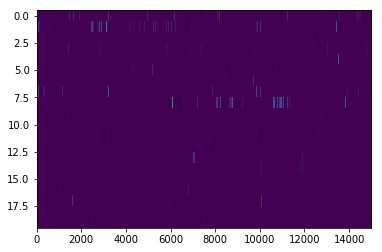

In [31]:
dp = packs[0]
dat = dp["planes"][0]["spikes"]
# plt.plot(dat)
plt.imshow(dat.T,aspect="auto")

In [11]:
import h5py
h5file = h5py.File('data.hdf5', 'w')
stokey = ["fluo","traces","spikes"]

for dat in packs:
    h5basepath = dat["hdf5path"]
    print(h5basepath)
    for p,plane in enumerate(dat["planes"]):
        for key in stokey:
            h5file.create_dataset("%s/p%i/%s"%(h5basepath,p,key), data=dat["planes"][p][key]) 
h5file.close()

imaging/date_2018_06_13/area1
imaging/date_2018_06_13/area2
imaging/date_2018_06_22/area1
imaging/date_2018_06_22/area2
imaging/date_2018_06_22/area3
imaging/date_2018_08_04/area1
imaging/date_2018_08_04/area2
imaging/date_2018_08_05/area1
imaging/date_2018_08_05/area2
imaging/date_2018_08_06/area1
imaging/date_2018_08_06/area2


In [12]:
h5file.close()